In [12]:
#Q2
#B1
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

dataset=Planetoid(root='/tmp/Cora', name='Cora')
data=dataset[0]

print(f'Number of nodes: {data.num_nodes}')
print(f'feature dimension: {dataset.num_features}')
print(f'number of classes: {dataset.num_classes}')

Number of nodes: 2708
feature dimension: 1433
number of classes: 7


In [18]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
      

        #message passing layers
        #input layer: dataset.num_features, output layer: dataset.num_classes
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        #first layer + activation function + second layer + log_softmax
        x = self.conv1(x, edge_index)
        x = x.relu()
        x=F.dropout(x,p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()

def train_gcn(model, optimizer):
    model.train()
    optimizer.zero_grad()

    #foward pass
    out = model(data.x, data.edge_index)
    #compute loss only on training nodes
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    #backward pass and optimization step
    loss.backward()
    optimizer.step()
    return loss.item()

def test_gcn(model):
    #evaluate the model on test nodes
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        acc = int((pred[data.test_mask] == data.y[data.test_mask]).sum()) / int(data.test_mask.sum())
    return acc



#seeds = [2,4,8,16]
seeds=[12345,42,2026]
gcn_accuracies = []

print(f"{'='*10} Start GCN (B1) Training {'='*10}")

for seed in seeds:
    torch.manual_seed(seed) 
    
    model = GCN(hidden_channels=16) 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    best_acc = 0
    for epoch in range(1, 201):
        loss = train_gcn(model, optimizer)
        acc = test_gcn(model)
        
        
        if acc > best_acc:
            best_acc = acc
            
    gcn_accuracies.append(best_acc)
    print(f"Seed {seed} Best Accuracy: {best_acc:.4f}")

mean_acc = torch.tensor(gcn_accuracies).mean().item()
std_acc = torch.tensor(gcn_accuracies).std().item()

print(f"\n[Part B1 Result] GCN Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


========== Start GCN (B1) Training ==========
Seed 12345 Best Accuracy: 0.8210
Seed 42 Best Accuracy: 0.8140
Seed 2026 Best Accuracy: 0.8100

[Part B1 Result] GCN Accuracy: 0.8150 ± 0.0056


In [30]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

#  D1 :define DeepGCN model with variable layers
class DeepGCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers):
        super(DeepGCN, self).__init__()
        torch.manual_seed(12345)
        self.convs = torch.nn.ModuleList()
        
        self.convs.append(GCNConv(dataset.num_features, hidden_channels))
        
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
            
        self.convs.append(GCNConv(hidden_channels, dataset.num_classes))

    def forward(self, x, edge_index):

        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1: 
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return F.log_softmax(x, dim=1)
    def get_embedding(self, x, edge_index):
        # take the output of the last hidden layer as node embeddings
        for i in range(len(self.convs) - 1): # only go through hidden layers
            x = self.convs[i](x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
        return x
    


In [ ]:
layers_list = [2, 4, 8, 16] 
d1_accuracies = []

print(f"{'='*10} Start D1: GCN Depth Study {'='*10}")

for l in layers_list:

    model = DeepGCN(hidden_channels=16, num_layers=l)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    best_acc = 0
    for epoch in range(1, 201):
        loss = train_gcn(model, optimizer) 
        acc = test_gcn(model)              
        if acc > best_acc:
            best_acc = acc
            
    d1_accuracies.append(best_acc)
    print(f"Layers: {l}, Best Accuracy: {best_acc:.4f}")

plt.figure()
plt.plot(layers_list, d1_accuracies, marker='o', label='GCN')
plt.xlabel('Number of Layers (L)')
plt.ylabel('Test Accuracy')
plt.title('D1: GCN Accuracy vs. Depth')
plt.grid(True)
plt.legend()
plt.show()

In [17]:
#B2
from torch_geometric.utils import to_dense_adj

#S=D^-1*A
#convert edge_index to dense adjacency matrix
A=to_dense_adj(data.edge_index)[0]

deg=A.sum(dim=1)
deg[deg==0]=1

D_inv=torch.diag(1/deg)
S=torch.mm(D_inv, A)
print("S matrix:")
print(S)

#Y_0
num_nodes=data.num_nodes
num_classes=dataset.num_classes
def run_label_propagation():
    Y_0=torch.zeros((num_nodes, num_classes))
    true_labels_one_hot=F.one_hot(data.y, num_classes).float()

    Y_t=Y_0.clone()

#loop until convergence
    alpha=0.9
    num_iterations=50

    for i in range(num_iterations):
        Y_t=alpha*torch.mm(S, Y_t)+(1-alpha)*Y_0
#assign true labels to training nodes
        Y_t[data.train_mask]=true_labels_one_hot[data.train_mask]

    model.eval()
    pred_lp=Y_t.argmax(dim=1)

    corrrect=(pred_lp[data.test_mask]==data.y[data.test_mask]).sum()
    acc=int(corrrect)/int(data.test_mask.sum())
    return acc

seeds=[12345,42,2026]
lp_accuracies=[]

print(f"{'='*10} Start Label Propagation (B2) Training {'='*10}")
for seed in seeds:
    torch.manual_seed(seed)
    acc=run_label_propagation()
    lp_accuracies.append(acc)
    print(f"Seed {seed} Accuracy: {acc:.4f}")

mean_acc_lp=torch.tensor(lp_accuracies).mean().item()
std_acc_lp=torch.tensor(lp_accuracies).std().item()

print(f"\n[Part B2 Result] LP Accuracy ± Std: {mean_acc_lp:.4f} ± {std_acc_lp:.4f}")


S matrix:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3333,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2500],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2500, 0.0000]])
========== Start Label Propagation (B2) Training ==========
Seed 12345 Accuracy: 0.7090
Seed 42 Accuracy: 0.7090
Seed 2026 Accuracy: 0.7090

[Part B2 Result] LP Accuracy ± Std: 0.7090 ± 0.0000



========== Start D2: LP Steps Study ==========
LP Steps: 2, Accuracy: 0.5020
LP Steps: 4, Accuracy: 0.6520
LP Steps: 8, Accuracy: 0.6890
LP Steps: 16, Accuracy: 0.7070
LP Steps: 32, Accuracy: 0.7090


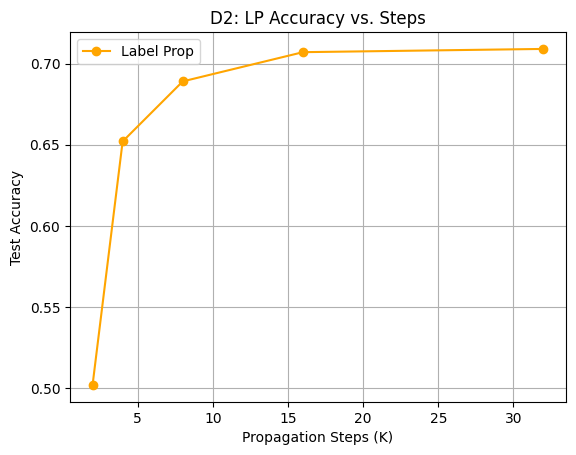

In [22]:
# D2
steps_list = [2, 4, 8, 16, 32]
d2_accuracies = []

print(f"\n{'='*10} Start D2: LP Steps Study {'='*10}")

# define a function to run LP with variable steps
def run_lp_with_k(k):
    Y0 = torch.zeros((num_nodes, num_classes))
    true_labels_one_hot = F.one_hot(data.y, num_classes).float()
    Y0[data.train_mask] = true_labels_one_hot[data.train_mask]
    Y_t = Y0.clone()
    alpha = 0.9
    
    for _ in range(k): 
        Y_t = alpha * torch.mm(S, Y_t) + (1 - alpha) * Y0
        Y_t[data.train_mask] = true_labels_one_hot[data.train_mask]
        
    pred = Y_t.argmax(dim=1)
    acc = int((pred[data.test_mask] == data.y[data.test_mask]).sum()) / int(data.test_mask.sum())
    return acc

for k in steps_list:
    acc = run_lp_with_k(k)
    d2_accuracies.append(acc)
    print(f"LP Steps: {k}, Accuracy: {acc:.4f}")


plt.figure()
plt.plot(steps_list, d2_accuracies, marker='o', color='orange', label='Label Prop')
plt.xlabel('Propagation Steps (K)')
plt.ylabel('Test Accuracy')
plt.title('D2: LP Accuracy vs. Steps')
plt.grid(True)
plt.legend()
plt.show()

In [33]:
#B3
A = to_dense_adj(data.edge_index)[0]
deg = A.sum(dim=1)
deg[deg == 0] = 1
D_inv = torch.diag(1.0 / deg)
S = torch.mm(D_inv, A)
class DecoupledGNN(torch.nn.Module):
    def __init__(self, hidden_channels,alpha,K):
        super(DecoupledGNN, self).__init__()
        # replace GCNConv with Linear layers
        self.lin1 = torch.nn.Linear(dataset.num_features, hidden_channels) 
        self.lin2 = torch.nn.Linear(hidden_channels, dataset.num_classes)

        self.alpha=alpha
        self.K=K

    def forward(self, x,S):
        
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)

        h0=x.clone()
        ht=x.clone()
        for _ in range(self.K):
            ht=self.alpha*torch.mm(S, ht)+(1-self.alpha)*h0
        return F.log_softmax(ht, dim=1)
    def get_embedding(self, x, S):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        
        h0 = x.clone()
        ht = x.clone()
        
        for _ in range(self.K):
            ht = self.alpha * torch.mm(S, ht) + (1 - self.alpha) * h0
            
        return ht
    
def train_decoupled(model_decoupled,optimizer,S):
    model_decoupled.train()
    optimizer.zero_grad()
    out = model_decoupled(data.x, S) 
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test_decoupled(model_decoupled,S):
    model_decoupled.eval()
    out = model_decoupled(data.x, S) 
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc



In [ ]:

#C
seeds=[12345,42,2026]
accuracies=[]

print(f"{'='*10}Start Decoupled GNN Training{'='*10}")

for seed in seeds:
    torch.manual_seed(seed)
    model_decoupled=DecoupledGNN(hidden_channels=16,alpha=0.9,K=10)
    optimizer_decoupled=torch.optim.Adam(model_decoupled.parameters(), lr=0.01, weight_decay=5e-4)

    best_acc=0
    for epoch in range(1,201):
        loss=train_decoupled(model_decoupled,optimizer_decoupled,S)
        acc=test_decoupled(model_decoupled,S)
        if acc>best_acc:
            best_acc=acc
       
    accuracies.append(best_acc)
    print(f'Seed: {seed}, Best Test Accuracy: {best_acc:.4f}')

mean_acc=torch.tensor(accuracies).mean().item()
std_acc=torch.tensor(accuracies).std().item()

print(f"\nFinal Result(Avg Accuracy ± Std): {mean_acc:.4f} ± {std_acc:.4f}")


========== Start D3: Decoupled Steps Study ==========
Decoupled Steps: 2, Best Accuracy: 0.8170
Decoupled Steps: 4, Best Accuracy: 0.8170
Decoupled Steps: 8, Best Accuracy: 0.8200
Decoupled Steps: 16, Best Accuracy: 0.8210
Decoupled Steps: 32, Best Accuracy: 0.8270


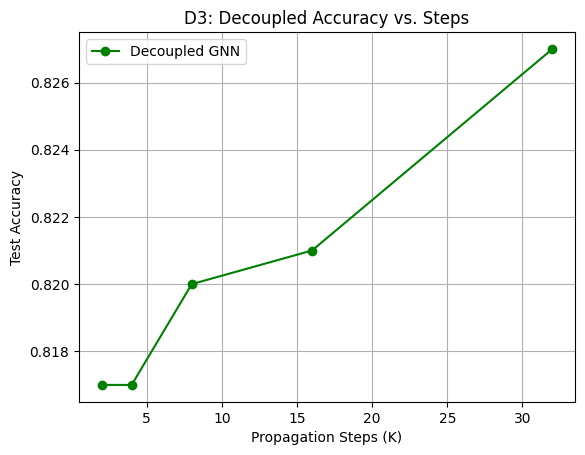

In [23]:
# D3
steps_list = [2, 4, 8, 16, 32]
d3_accuracies = []

print(f"\n{'='*10} Start D3: Decoupled Steps Study {'='*10}")

for k in steps_list:
    torch.manual_seed(12345)
    # initialize model and optimizer for each K
    model = DecoupledGNN(hidden_channels=16, alpha=0.9, K=k)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    # train and evaluate the model, keeping track of the best accuracy
    best_acc = 0
    for epoch in range(1, 201):
        loss = train_decoupled(model, optimizer, S) 
        acc = test_decoupled(model, S)              
        if acc > best_acc:
            best_acc = acc
            
    d3_accuracies.append(best_acc)
    print(f"Decoupled Steps: {k}, Best Accuracy: {best_acc:.4f}")


plt.figure()
plt.plot(steps_list, d3_accuracies, marker='o', color='green', label='Decoupled GNN')
plt.xlabel('Propagation Steps (K)')
plt.ylabel('Test Accuracy')
plt.title('D3: Decoupled Accuracy vs. Steps')
plt.grid(True)
plt.legend()
plt.show()

Training GCN Shallow (L=2)...


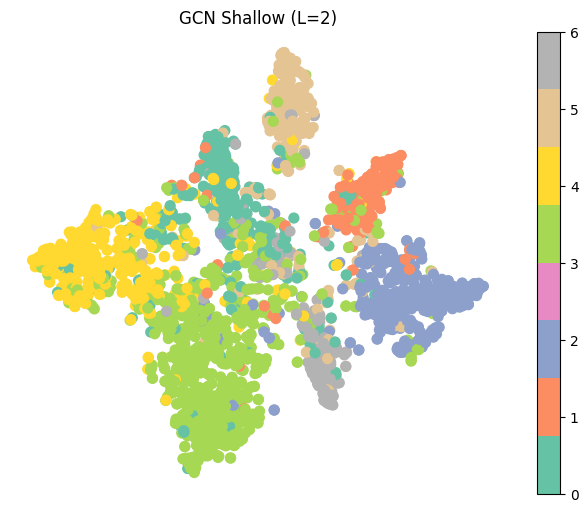

Training GCN Deep (L=16)...


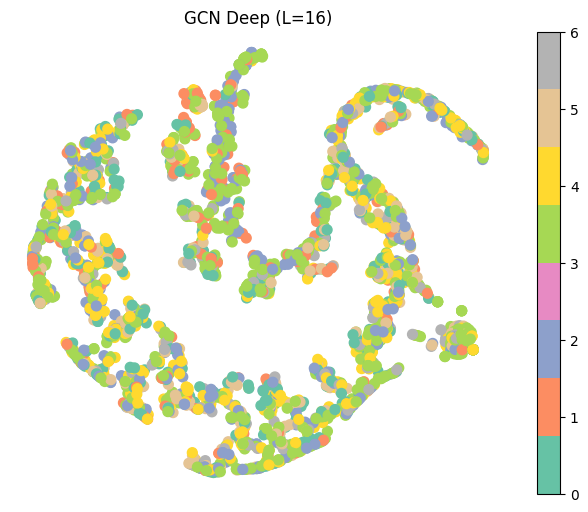

Training Decoupled Shallow (K=10)...


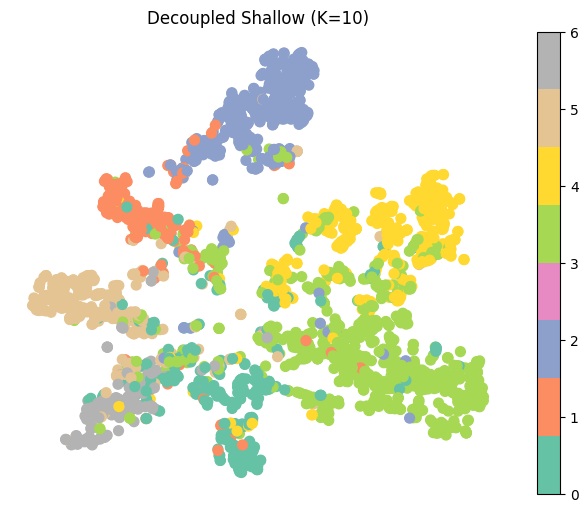

Training Decoupled Deep (K=32)...


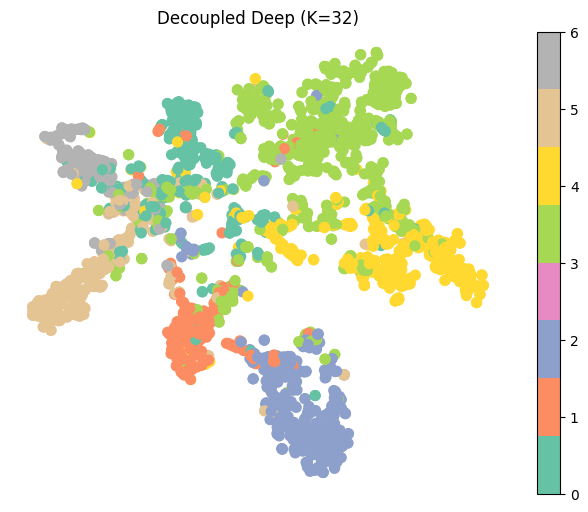

In [34]:
#E
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embedding(h, color, title):
    z = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(8, 6))
    plt.scatter(z[:, 0], z[:, 1], s=50, c=color.cpu().numpy(), cmap="Set2")
    plt.title(title)
    plt.axis('off')
    plt.colorbar()
    plt.show()
def train_and_visualize(model_type, param, title):
    print(f"Training {title}...")
    
    # 实例化模型
    if model_type == 'GCN':
        model = DeepGCN(hidden_channels=16, num_layers=param)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    else: # Decoupled
        model = DecoupledGNN(hidden_channels=16, alpha=0.9, K=param)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    # 快速训练 100 轮 (足够出效果了)
    model.train()
    for epoch in range(100):
        optimizer.zero_grad()
        if model_type == 'GCN':
            out = model(data.x, data.edge_index)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        else:
            out = model(data.x, S)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    # 提取特征并画图
    model.eval()
    if model_type == 'GCN':
        emb = model.get_embedding(data.x, data.edge_index)
    else:
        emb = model.get_embedding(data.x, S)
    
    visualize_embedding(emb, data.y, title)



# 1. GCN Shallow (L=2) 
train_and_visualize('GCN', param=2, title="GCN Shallow (L=2)")

# 2. GCN Deep (L=16)  (Over-smoothing)
train_and_visualize('GCN', param=16, title="GCN Deep (L=16)")

# 3. Decoupled Shallow (K=10) 
train_and_visualize('Decoupled', param=10, title="Decoupled Shallow (K=10)")

# 4. Decoupled Deep (K=32) 
train_and_visualize('Decoupled', param=32, title="Decoupled Deep (K=32)")